<a href="https://colab.research.google.com/github/brian-ho/intro-to-urban-data/blob/main/Scale/S01_Grasshopper_and_wiring_it_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **06 Measure** Grasshopper and wiring it all up
```
    Class       ARCH 6131 Urban Design Methods / Skills / Tools 1
                The Gensler Family AAP NYC Center
                Fall 2023
                Monday 3:30 PM to 6 PM

    Instructor  Brian Ho
                brian@brian-ho.io
```

This notebook shows how you can put together the individual pieces of this Module. It assumes you've worked through the previous notebooks in the module! If you haven't, definitely run through them in advance.

Let's say we want to create a drawing the locates photographs on the map, and annotates them with their color inforrmation. In this notebook we will:

- Load in images and external files
- Create data from the image
- Write that data to Rhino
- Use Grasshopper to add other details

In [1]:
!pip install https://intro-to-urban-data.s3.amazonaws.com/rhino3dm-8.0.0b2-cp310-cp310-linux_x86_64.whl --quiet
!pip install pillow-heif geoplot --quiet

## Load in images and get data
As before, we'll connect to Google Drive and use existing Python packages to load in image files.

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import rhino3dm
import PIL
import geopandas as gpd
import pandas as pd
import os
from pillow_heif import register_heif_opener
from pathlib import Path
from shapely.geometry import Point
from shapely.ops import orient
import geoplot

# This helps us open HEIC files
register_heif_opener()

# This gives us a set of image file extensions
IMAGE_FILE_EXTENSIONS = {
    ex.lower() for ex, f in PIL.Image.registered_extensions().items() if f in PIL.Image.OPEN
}
IMAGE_FILE_EXTENSIONS.add(".HEIC".lower())

In [4]:
DATA_DIRECTORY = '/content/drive/MyDrive/Cornell AAP - MSAUD/ARCH 6131/Example Data'

In [5]:
GPS_LAT_REF = "GPSLatitudeRef"
GPS_LAT = "GPSLatitude"
GPS_LNG_REF = "GPSLongitudeRef"
GPS_LNG = "GPSLongitude"
GPS_IMG_DIRECTION = "GPSImgDirection"

# For each image, we'll want to know the location, longitude, and bearing
def parse_degrees_to_decimals(degrees, reference):
    """Transforms angular degrees into decimal degrees."""

    sign = -1.0 if reference in ("S", "W") else 1.0
    decimals = degrees[0] + degrees[1] / 60 + (degrees[2] / (60 * 60))
    return decimals * sign

def get_gps_data(img):
    """Gets the direction, latitude, and longitude from an image."""

    img_exif = img.getexif()
    gps_data = {
        'direction': None,
        'latitude': None,
        'longitude': None,
    }

    try:
        all_gps = img_exif.get_ifd(PIL.ExifTags.IFD.GPSInfo)
        gps_info = {}

        for tag, value in all_gps.items():
            tag_name = PIL.ExifTags.GPSTAGS.get(tag, tag)
            gps_info[tag_name] = value

        gps_data['direction'] = gps_info[GPS_IMG_DIRECTION]
        gps_data['latitude'] = parse_degrees_to_decimals(gps_info[GPS_LAT], gps_info[GPS_LAT_REF])
        gps_data['longitude'] = parse_degrees_to_decimals(gps_info[GPS_LNG], gps_info[GPS_LNG_REF])

    except KeyError:
        pass

    return gps_data

def palette_color_to_rgb(palette, color):
    return [v / 255.0 for v in palette[color * 3 : color * 3 + 3]]


def get_color_data(img):
    """Gets the 10 most common colors in an image."""
    converted_img = img.convert('P')
    palette = converted_img.getpalette()
    converted_img.thumbnail((100, 100))

    color_counts = converted_img.getcolors()
    color_counts.sort(key=lambda x: x[0] ,reverse=True)

    return {f'color_{i}': (k, palette_color_to_rgb(palette, v)) for i, (k, v) in enumerate(color_counts[:10])}


# And we'll fetch this from the
def get_gps_info(img_file):
    """Get all the information we want for an image."""

    # Create a PIL Image object
    img = PIL.Image.open(img_file)

    img_data = {
        'file_name': img_file.name,
        **get_gps_data(img),
        **get_color_data(img),
    }

    img.close()

    return img_data

In [7]:
images_data = []

for filepath in os.listdir(DATA_DIRECTORY):
    if any(filepath.lower().endswith(ext) for ext in IMAGE_FILE_EXTENSIONS):
        gps_data = get_gps_info(Path(DATA_DIRECTORY) / filepath)
        images_data.append(gps_data)

images_data[0]

{'file_name': 'IMG_1605.HEIC',
 'direction': 109.22115325693976,
 'latitude': 40.715825,
 'longitude': -73.99926666666667,
 'color_0': (1382, [0.4, 0.4, 0.4]),
 'color_1': (905, [0.2, 0.2, 0.2]),
 'color_2': (688, [0.6, 0.6, 0.6]),
 'color_3': (451, [0.8, 0.8, 0.8]),
 'color_4': (390, [0.4, 0.4, 0.2]),
 'color_5': (301, [0.6, 0.4, 0.4]),
 'color_6': (299, [1.0, 1.0, 1.0]),
 'color_7': (255, [0.4, 0.2, 0.2]),
 'color_8': (204, [0.0, 0.0, 0.0]),
 'color_9': (201, [0.6, 0.6, 0.4])}

## Load in map data

In [8]:
# https://epsg.io/2263
buildings_gdf = gpd.read_file(Path(DATA_DIRECTORY) / 'buildings.geojson').to_crs(2263)
nyc_gdf = gpd.read_file(geoplot.datasets.get_path("nyc_boroughs")).to_crs(2263)

<Axes: >

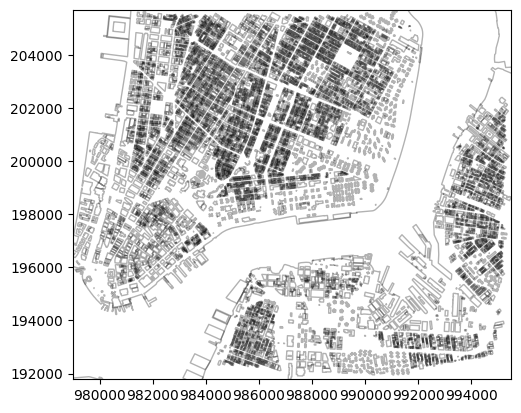

In [9]:
bounds = buildings_gdf.geometry.total_bounds

plt = pd.concat([buildings_gdf, nyc_gdf]).plot(facecolor='none', alpha=0.3)
plt.set_xlim(bounds[0], bounds[2])
plt.set_ylim(bounds[1], bounds[3])
plt

In [11]:
point_geoms = [Point(img['longitude'], img['latitude']) for img in images_data]
all_images_gdf = gpd.GeoDataFrame(images_data, geometry=point_geoms, crs=4326).to_crs(2263)

There are 2009 buildings within 1,600 feet of all the images.


<Axes: >

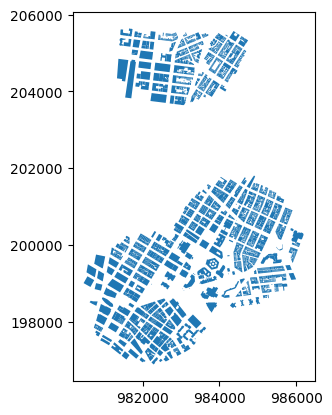

In [12]:
all_images_buffer = all_images_gdf.unary_union.buffer(1600)

buildings_around_images_gdf = buildings_gdf[buildings_gdf['geometry'].intersects(all_images_buffer)].copy()
print(f'There are {len(buildings_around_images_gdf)} buildings within 1,600 feet of all the images.')
buildings_around_images_gdf.plot()

In [13]:
buildings_around_images_gdf.head(5)

,base_bbl,cnstrct_yr,doitt_id,groundelev,heightroof,mpluto_bbl,name,geometry
15,1003040035,1910.0,214723.0,40.0,65.14,1003040035,NaN,"POLYGON ((985742.670 200588.703, 985777.636 20..."
25,1002390008,1910.0,92314.0,36.0,72.24,1002390008,NaN,"POLYGON ((985401.628 200902.798, 985403.056 20..."
27,1002350004,1915.0,585548.0,21.0,80.26,1002350004,NaN,"POLYGON ((984592.734 201190.908, 984595.614 20..."
29,1005280082,1896.0,309719.0,12.0,73.84,1005280082,NaN,"POLYGON ((983095.557 204958.493, 983060.855 20..."
30,1002800038,1910.0,428455.0,36.0,79.58,1002800038,NaN,"POLYGON ((985395.667 199213.831, 985398.973 19..."


In [14]:
buildings_around_images_gdf['extrusion_height'] = buildings_around_images_gdf['heightroof'] - buildings_around_images_gdf['groundelev']

## Write data to Rhino

In [15]:
# Make an empty fiie
new_3dm = rhino3dm.File3dm()
new_3dm.Layers.AddLayer('BASE', (255, 255, 255, 255))

0

In [16]:
def create_extrusion(geometry, height):
    polyline_curve = rhino3dm.Polyline(
        [
            rhino3dm.Point3d(x, y, 0) for (x, y) in orient(geometry).exterior.coords
        ]
    ).ToPolylineCurve()

    return rhino3dm.Extrusion.Create(polyline_curve, height=height, cap=True)

In [17]:
for i, building in buildings_around_images_gdf.iterrows():
    extrusion = create_extrusion(building['geometry'], building['heightroof'])
    new_3dm.Objects.Add(extrusion)

In [18]:
for i, borough in nyc_gdf.explode(index_parts=False).iterrows():
    polyline_curve = rhino3dm.Polyline(
        [
            rhino3dm.Point3d(x, y, 0) for (x, y) in orient(borough['geometry']).exterior.coords
        ]
    ).ToPolylineCurve()
    new_3dm.Objects.Add(polyline_curve)

In [19]:
for i, building in buildings_around_images_gdf.iterrows():
    extrusion = create_extrusion(building['geometry'], building['heightroof'])
    new_3dm.Objects.Add(extrusion)

In [20]:
# Add the layer with a name and color
for i, img in all_images_gdf.iterrows():
    most_common_color = img['color_1']
    r, g, b = (int(v * 255) for v in most_common_color[1])
    layer_index = new_3dm.Layers.AddLayer(img['file_name'], (r, g, b, 255))

    attributes = rhino3dm.ObjectAttributes()
    attributes.LayerIndex = layer_index
    point = rhino3dm.Point(rhino3dm.Point3d(img['geometry'].x, img['geometry'].y, 0))
    new_3dm.Objects.Add(point, attributes)

In [21]:
new_3dm.Write('example.3dm', version=7)

True

## Use Grasshopper to add in other details

In [22]:
all_images_df = pd.DataFrame(all_images_gdf)
all_images_df['longitude'] = all_images_df['geometry'].apply(lambda pt: pt.x)
all_images_df['latitude'] = all_images_df['geometry'].apply(lambda pt: pt.y)

all_images_df.to_csv('example.csv', index=False, sep=';')